# Discrete LTI Systems

首先引入 NumPy, SciPy.signal, Matplotlib, LibROSA 等必要的库。

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

import librosa as rosa
import librosa.display
from IPython.display import Audio

from ipywidgets import interact

np.set_printoptions(suppress=True)
rosa.version.show_versions()

INSTALLED VERSIONS
------------------
python: 3.8.13 (default, Mar 28 2022, 06:16:26) 
[Clang 12.0.0 ]

librosa: 0.9.2

audioread: 3.0.0
numpy: 1.23.1
scipy: 1.8.1
sklearn: 1.1.2
joblib: 1.2.0
decorator: 5.1.1
soundfile: 0.11.0
resampy: 0.4.2
numba: 0.56.2
pooch: v1.6.0
packaging: 21.3

numpydoc: 1.4.0
sphinx: 5.0.2
sphinx_rtd_theme: None
sphinx_multiversion: None
sphinx_gallery: None
mir_eval: None
ipython: None
sphinxcontrib-svg2pdfconverter: None
pytest: 7.1.3
pytest-mpl: None
pytest-cov: None
matplotlib: 3.5.2
samplerate: None
soxr: None
contextlib2: None
presets: None


定义两个常用的函数，用于画零极点图和输入输出对比图。

In [3]:
def draw_pzmap(dlti):
    plt.plot(np.real(dlti.zeros), np.imag(dlti.zeros), 'o', mfc='none')
    plt.plot(np.real(dlti.poles), np.imag(dlti.poles), 'x')
    w = np.linspace(0, 2*np.pi)
    plt.plot(np.cos(w), np.sin(w), 'y--')
    limits = plt.axis("equal")
    plt.grid()
    
def draw_resp_stem(x, y):
    plt.stem(x, use_line_collection=True)
    (markerline, _, _) = plt.stem(y, linefmt='r', markerfmt='ro', use_line_collection=True)
    markerline.set_markerfacecolor('none')
    

In [4]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 7.31.1
ipykernel        : 6.15.2
ipywidgets       : 7.6.5
jupyter_client   : 7.1.2
jupyter_core     : 4.9.1
jupyter_server   : 1.18.1
jupyterlab       : 3.4.4
nbclient         : 0.5.13
nbconvert        : 6.4.4
nbformat         : 5.5.0
notebook         : 6.4.12
qtconsole        : 5.2.2
traitlets        : 5.1.1


## DLTI的两种基本形式： FIR与IIR
DLTI系统有两种基本形式，通常的名字是FIR和IIR，主要区别是系统是否有记忆，即当前输出是否与过去的输出有关。
FIR其实就是输入的加权移动平均(Weighted Moving Average, WMA for short)

$$
\begin{aligned}
y[n]  &= \sum_{i=0}^{L}b[i]x[n-i] \\
      &= b[0]x[n] + b[1]x[n-1] + \cdots + b[L]x[n-L]
\end{aligned}
$$

根据以上定义我们可以很容易卸除自己的WMA实现，而SciPy里也有很多办法计算WMA，包括
* [scipy.signal.convolve] [aconvolve] [fftconvolve]
* [scipy.signal.lfilter]
* [scipy.signal.dlsim]
* [scipy.signal.dlti.output]

FIR其实也可以看成是最简单的前向神经网络， 没有bias，也没有activation function, 输出完全是输入按不同权重的线性组合。

WMA的实现是两重循环，内循环负责加权求和，外循环负责移动。
以下代码的“加权求和”这一步用“NumPy.dot()”实现，比较简洁。
'dot()' 是计算两个向量的点积，也叫内积。

In [6]:
from typing import Sequence

def direct_wma(b: Sequence, x: Sequence) -> Sequence:
    y = np.zeros(len(x))
    x_pad = np.concatenate((np.zeros(len(b) - 1), x))
    b_rev = np.array(b[::-1], dtype='d')
    for i in range(len(x)):
        y[i] = np.dot(b_rev, x_pad[i : i + len(b)])
    return y

用我们自己实现的`direct_wma()`来计算 $y[n] = 2x[n] + x[n-1]$.

In [7]:
b = [2, 1]
x = np.arange(10, dtype='d')
y = direct_wma(b, x)
print(np.array([x, y]).T)

[[ 0.  0.]
 [ 1.  2.]
 [ 2.  5.]
 [ 3.  8.]
 [ 4. 11.]
 [ 5. 14.]
 [ 6. 17.]
 [ 7. 20.]
 [ 8. 23.]
 [ 9. 26.]]


计算结果和 `scipy.signal.lfilter()`是一致的。

In [9]:
# b 和 x 同上
y = signal.lfilter(b, [1], x)
print((np.array([x, y]).T))

[[ 0.  0.]
 [ 1.  2.]
 [ 2.  5.]
 [ 3.  8.]
 [ 4. 11.]
 [ 5. 14.]
 [ 6. 17.]
 [ 7. 20.]
 [ 8. 23.]
 [ 9. 26.]]


第二种形式 IIR, 是在FIR基础上，把过去的输出也用来计算新的输出。这种形式过去也叫梯子（ladder），或格子(lattice),是比较形象的说法。
$$
\begin{aligned}
y[n] = &\sum_{i=0}^{L}b[i]x[n-i] - \sum_{i=1}^{M}a[i\,]y[n-i\,] \\
= & b[0]x[n] + b[1]x[n-1] + \cdots + b[L]x[n-L] \\
& -(a[1]y[n-1] + a[2]y[n-2] + \cdots + a[m]y[n-m])
\end{aligned}
$$

SciPy里提供了多种实现，本文以下主要使用第一个 `scipy.signal.lfilter()`来计算输出，而用第三个`scipy.signal.dlti` class来分析离散线性时不变系统（频率响应、冲击响应、零极点等等。）

* [scipy.signal.lfilter]
* [scipy.signal.dlsim]
* [scipy.signal.dlti.output]

有的领域把这种形式叫“自回归”autoregressive （特指用到当前的输入和过去的输出），
如果同时用到了过去的输入和过去的输出，那和前面的移动平均和在一起，叫 [ARMA模型]

这也可以堪称最简单的循环神经网络(RNN),没有bias,也没有activation function,只有两个权重。

# Moving average

### $N = 2$
$
y[n] = \frac{1}{2}x[n] + \frac{1}{2}x[n-1]
$

In [10]:
b = [1/2, 1/2]

x = np.arange(11)
y = signal.lfilter(b, [1], x) # or signal.convolve(b, x)
print(np.array([x, y]).T)

[[ 0.   0. ]
 [ 1.   0.5]
 [ 2.   1.5]
 [ 3.   2.5]
 [ 4.   3.5]
 [ 5.   4.5]
 [ 6.   5.5]
 [ 7.   6.5]
 [ 8.   7.5]
 [ 9.   8.5]
 [10.   9.5]]


`scipy.signal.dlti` Discrete-time linear time invariant system

Zeros: [-1.]
Poles: []


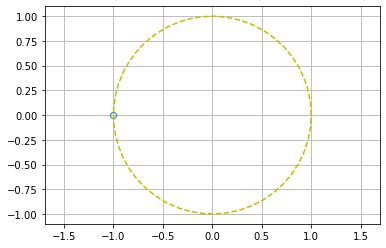

In [11]:
dlti = signal.dlti(b, [1])
print('Zeros:', dlti.zeros)
print('Poles:', dlti.poles)
draw_pzmap(dlti)

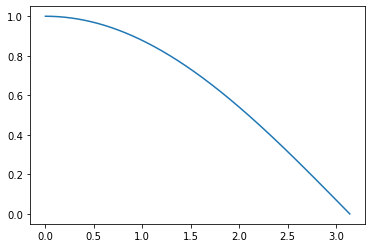

In [12]:
w, mag = dlti.freqresp()
plt.plot(w, np.abs(mag))

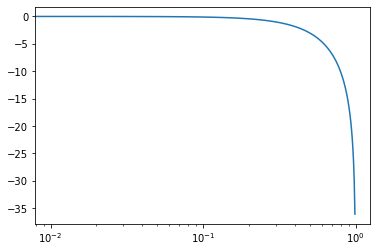

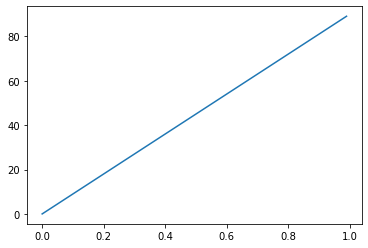

In [13]:
w, mag, phase = dlti.bode()
plt.semilogx(w/np.pi, mag)
plt.figure(2)
plt.plot(w/np.pi, phase)

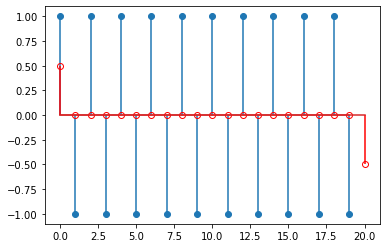

In [14]:
w = np.arange(20) * np.pi
x = np.cos(w) # [1, -1, 1, -1, ...]
y = np.convolve(b, x)

draw_resp_stem(x, y)

In [15]:
@interact(f = (0, 1, 0.02))
def resp(f = 0.5):
    t = np.linspace(0, 1, 101)
    x = np.cos(t * 2*np.pi * f * 100)
    plt.plot(t, x)
    y = signal.lfilter([1/2, 1/2], [1], x)
    plt.plot(t, y)
    plt.show()

interactive(children=(FloatSlider(value=0.5, description='f', max=1.0, step=0.02), Output()), _dom_classes=('w…

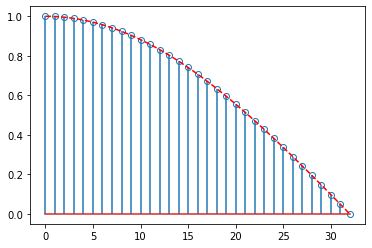

In [16]:
fft = np.fft.rfft([1/2, 1/2], n=64) #zero padding
(marker, _, _) = plt.stem(np.abs(fft), use_line_collection=True)
marker.set_markerfacecolor('none')

fr = dlti.freqresp(w=np.linspace(0, 1, len(fft)) * np.pi)[1]
plt.plot(np.abs(fr), 'r--')

### $N = 3$
$y[n] = \frac{1}{3}x[n] + \frac{1}{3}x[n-1] + \frac{1}{3}x[n-2]$ 

min_mag = -84.37 dB


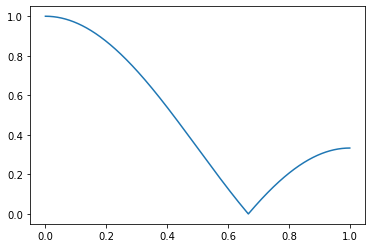

In [17]:
b3 = [1/3, 1/3, 1/3]
dlti3 = signal.dlti(b3, [1])

w, mag = dlti3.freqresp()
plt.plot(w/np.pi, np.abs(mag))
print('min_mag = %.2f dB' % (20 * np.log10(np.min(np.abs(mag)))))

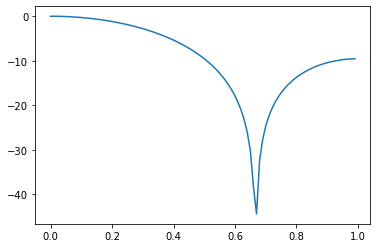

In [18]:
w, mag, phase = dlti3.bode()
plt.plot(w/np.pi, mag)

[ 120. -120.]


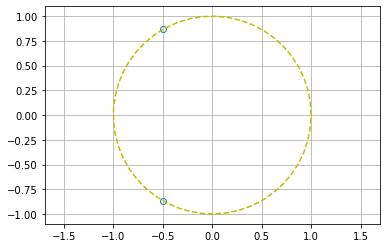

In [19]:
draw_pzmap(dlti3)
print(np.angle(dlti3.zeros)/np.pi*180)

[ 1.  -0.5 -0.5  1.  -0.5 -0.5  1.  -0.5 -0.5  1. ]


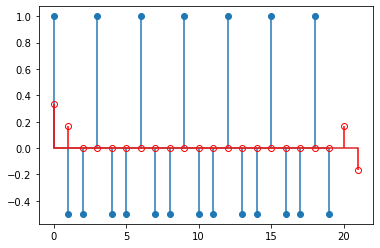

In [20]:
t = np.arange(20)
x = np.cos(t * 2/3 * np.pi)
y = np.convolve(x, b3)

draw_resp_stem(x, y)
print(x[0:10])

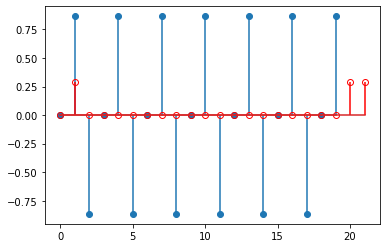

In [21]:
t = np.arange(20)
x = np.sin(t * 2/3 * np.pi)
y = np.convolve(x, b3)
draw_resp_stem(x, y)

In [27]:
@interact(phase=(0, 90, 5))
def resp(phase=45):
    t = np.arange(15)
    x = np.sin(t * 2/3 * np.pi- phase / 180 * np.pi)
    y = signal.lfilter(b3, [1], x)
    plt.stem(t, x, use_line_collection=True)
    t1 = np.arange(141) / 10
    plt.plot(t1, np.sin(t1 * 2/3 * np.pi - phase / 180 * np.pi), 'y--')
    (markerline, stemline, baseline) = plt.stem(t, y, linefmt='r', markerfmt='ro', use_line_collection=True)
    markerline.set_markerfacecolor('none')


interactive(children=(IntSlider(value=45, description='phase', max=90, step=5), Output()), _dom_classes=('widg…

### $N = 4$

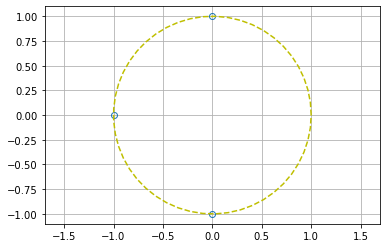

In [23]:
b4 = np.ones(4) / 4.0
dlti4 = signal.dlti(b4, [1])
draw_pzmap(dlti4)

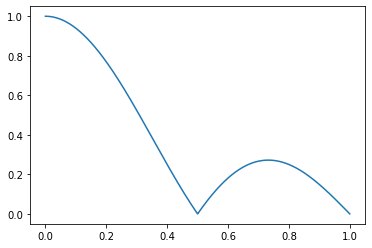

In [24]:
w, mag = dlti4.freqresp()
plt.plot(w/np.pi, np.abs(mag))

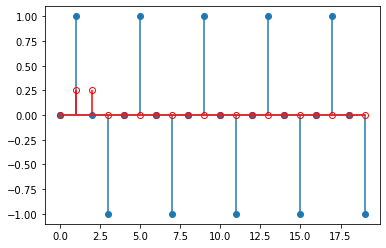

In [25]:
x = np.array([0, 1, 0, -1] * 5)
y = signal.lfilter(b4, [1], x)

draw_resp_stem(x, y)

In [26]:
@interact(phase=(0, 90, 5))
def resp(phase=30):
    t = np.arange(16)
    x = np.cos(t * 1/2 * np.pi - phase / 180 * np.pi)
    y = signal.lfilter(b4, [1], x)
    plt.stem(t, x, use_line_collection=True)
    t1 = np.arange(151) / 10
    plt.plot(t1, np.cos(t1 * 1/2 * np.pi - phase/180 * np.pi), 'y--')
    (markerline, stemlines, baseline) = plt.stem(t, y, linefmt='r', markerfmt='ro', use_line_collection=True)
    markerline.set_markerfacecolor('none')

interactive(children=(IntSlider(value=30, description='phase', max=90, step=5), Output()), _dom_classes=('widg…

# Differentiator
$y[n] = x[n] - x[n-1]$

In [28]:
bd = [1, -1]
x = np.arange(10, dtype='d') ** 2
print(x)
y = signal.lfilter(bd, [1], x)
print(y)
z = signal.lfilter(bd, [1], y)
print(z)

[ 0.  1.  4.  9. 16. 25. 36. 49. 64. 81.]
[ 0.  1.  3.  5.  7.  9. 11. 13. 15. 17.]
[0. 1. 2. 2. 2. 2. 2. 2. 2. 2.]


Zeros: [1.]
Poles: []


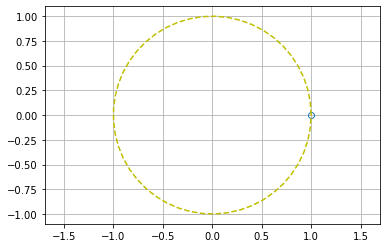

In [29]:
dlti = signal.dlti(bd, [1])
zeros = dlti.zeros
print('Zeros:', zeros)
print('Poles:', dlti.poles)
draw_pzmap(dlti)

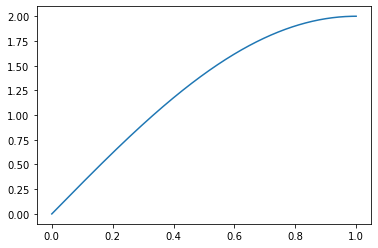

In [30]:
w, mag = dlti.freqresp()
plt.plot(w/np.pi, np.abs(mag))

# Eigenfunction


In [32]:
x = 2.0 ** np.arange(14)

y = signal.lfilter(bd, [1], x)
z = signal.lfilter(bd, [1], y)
w = signal.lfilter(bd, [1], z)
np.array([x, y, z, w]).T

array([[   1.,    1.,    1.,    1.],
       [   2.,    1.,    0.,   -1.],
       [   4.,    2.,    1.,    1.],
       [   8.,    4.,    2.,    1.],
       [  16.,    8.,    4.,    2.],
       [  32.,   16.,    8.,    4.],
       [  64.,   32.,   16.,    8.],
       [ 128.,   64.,   32.,   16.],
       [ 256.,  128.,   64.,   32.],
       [ 512.,  256.,  128.,   64.],
       [1024.,  512.,  256.,  128.],
       [2048., 1024.,  512.,  256.],
       [4096., 2048., 1024.,  512.],
       [8192., 4096., 2048., 1024.]])

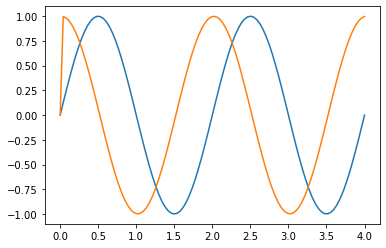

In [34]:
t = np.linspace(0, 1, 100) * 4 * np.pi
x = np.sin(t)
y = signal.lfilter(bd, [1], x)
plt.plot(t/np.pi, x)
plt.plot(t/np.pi, y/(t[1] - t[0]))

# Recursive
自回归

## Accumulator, integrator 
$y[n] = x[n] + y[n-1]$ <br>
$H(z) = \frac{1}{1 - z^{-1}}$

zeros:  []
poles:  [1.]


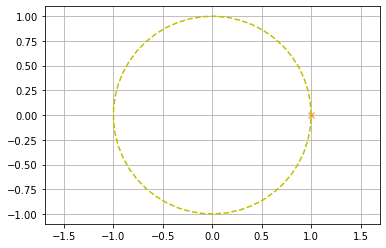

In [35]:
dlti = signal.dlti([1], [1, -1])
draw_pzmap(dlti)
print("zeros: ", dlti.zeros)
print("poles: ", dlti.poles)

In [37]:
b = [1]
a = [1, -1]
x = np.zeros(11)
x[1] = 1
print(x)
y = signal.lfilter(b, a, x=x)
print(y)
z = signal.lfilter(b, a, y)
print(z)
w = signal.lfilter(b, a, z)
print(w)

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[ 0.  1.  3.  6. 10. 15. 21. 28. 36. 45. 55.]


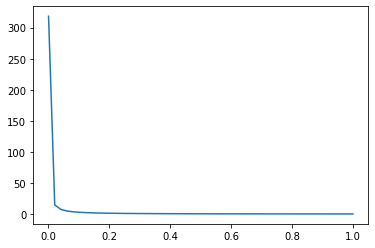

In [38]:
w, mag = dlti.freqresp(w=np.linspace(np.pi/1000, np.pi))
plt.plot(w/np.pi, np.abs(mag))

<StemContainer object of 3 artists>

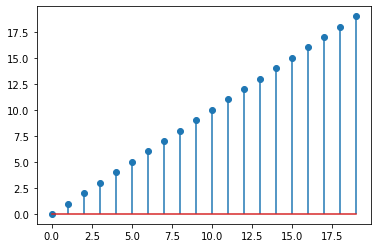

In [39]:
t, y = dlti.step(n=20)
plt.stem(t, y[0], use_line_collection=True)

<StemContainer object of 3 artists>

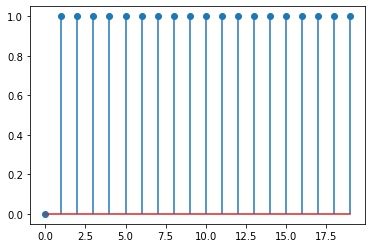

In [40]:
t, y = dlti.impulse(n=20)
plt.stem(t, y[0], use_line_collection=True)

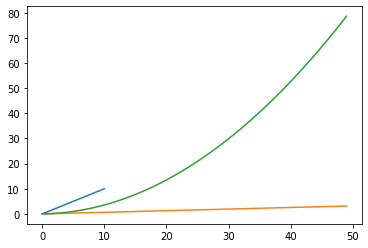

In [41]:
w3 = signal.lfilter(b, a, w)
plt.plot(z) #linear
plt.plot(w) #quadratic
plt.plot(w3) #3-order